# Quality Assessment Metrics

In [1]:
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scripts.io import read_image, KEY_INPUT_EO, KEY_INPUT_SAR, KEY_OUTPUT_SAR
from scripts.utils import c2ap, T, invT, standardize, clip
from skimage import exposure

In [2]:
baseline_directory = '../methods/'
METHOD_LIST = ['gbf', 'gnlm', 'tbog', 'aef']

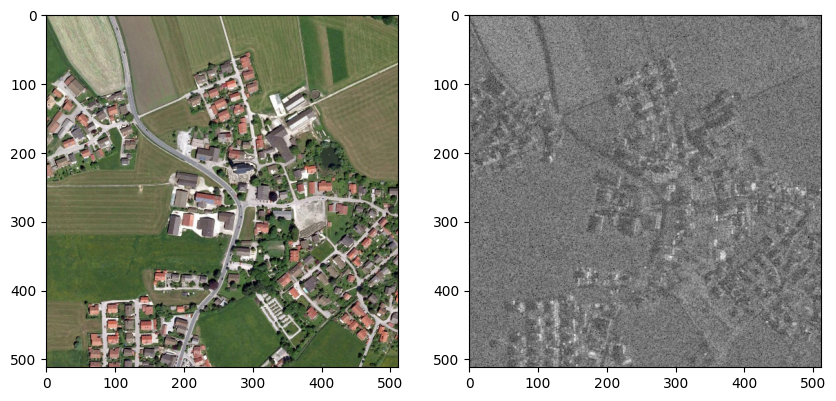

In [6]:
input_path = "../../dataset/data_village.npz"

sar = read_image(input_path, key=KEY_INPUT_SAR).squeeze()
eo = read_image(input_path, key=KEY_INPUT_EO)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(eo)
plt.subplot(1, 2, 2)
plt.imshow(T(sar)[0], cmap='gray')

In [9]:
results_dict = {}

for m in METHOD_LIST:
    filenames = os.listdir(os.path.join(baseline_directory, m, 'results'))
    for f in filenames:
        if f.endswith('.mat') and 'village' in f:
            result_path = os.path.join(baseline_directory, m, 'results', f)

            filtered_data = read_image(result_path, key=KEY_OUTPUT_SAR)
            filtered_data, _ = c2ap(filtered_data)

            results_dict[m] = filtered_data

results_dict.keys()

dict_keys(['gbf', 'gnlm', 'tbog'])

Text(0.5, 1.0, 'TBOG Standardized')

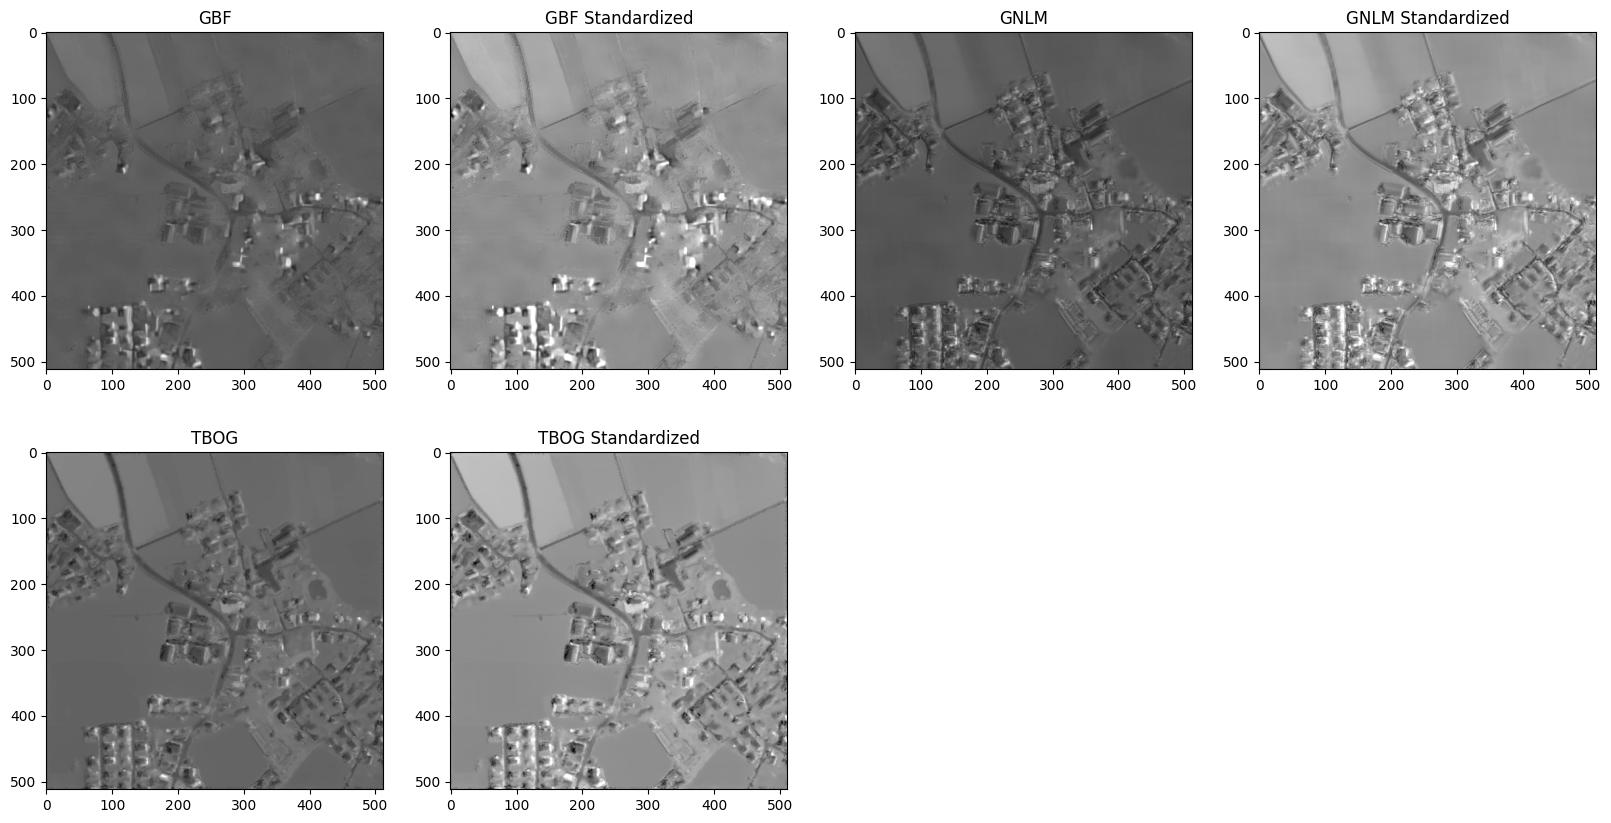

In [9]:
output_gbf = results_dict['gbf']
output_gnlm = results_dict['gnlm']
output_tbog = results_dict['tbog']

output_gbf_standardized, gbf_transforms_params = standardize(np.clip(output_gbf, 0, 255))
output_gnlm_standardized, gnlm_transforms_params = standardize(np.clip(output_gnlm, 0, 255))
output_tbog_standardized, tbog_transforms_params = standardize(np.clip(output_tbog, 0, 255))

output_gbf_standardized = exposure.rescale_intensity(output_gbf_standardized, in_range=(-5, 5), out_range=(0, 1))
output_gnlm_standardized = exposure.rescale_intensity(output_gnlm_standardized, in_range=(-5, 5), out_range=(0, 1))
output_tbog_standardized = exposure.rescale_intensity(output_tbog_standardized, in_range=(-5, 5), out_range=(0, 1))

output_gbf_standardized = exposure.adjust_gamma(output_gbf_standardized, gamma=0.8, gain=1.0).squeeze()
output_gnlm_standardized = exposure.adjust_gamma(output_gnlm_standardized, gamma=0.8, gain=1.0).squeeze()
output_tbog_standardized = exposure.adjust_gamma(output_tbog_standardized, gamma=0.8, gain=1.0).squeeze()

plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
plt.imshow(output_gbf, cmap='gray')
plt.title('GBF')
plt.subplot(2, 4, 2)
plt.imshow(output_gbf_standardized, cmap='gray')
plt.title('GBF Standardized')
plt.subplot(2, 4, 3)
plt.imshow(output_gnlm, cmap='gray')
plt.title('GNLM')
plt.subplot(2, 4, 4)
plt.imshow(output_gnlm_standardized, cmap='gray')
plt.title('GNLM Standardized')
plt.subplot(2, 4, 5)
plt.imshow(output_tbog, cmap='gray')
plt.title('TBOG')
plt.subplot(2, 4, 6)
plt.imshow(output_tbog_standardized, cmap='gray')
plt.title('TBOG Standardized')

In [40]:
# plt.figure(figsize=(15, 10))
# plt.subplot(2, 3, 1)
# plt.imshow(eo_annotated)
# plt.title('EO')
# plt.subplot(2, 3, 2)
# plt.imshow(sar_annotated, cmap='gray')
# plt.title('SAR')
# plt.subplot(2, 3, 4)
# plt.imshow(output_gbf_standardized, cmap='gray')
# plt.title('GBF')
# plt.subplot(2, 3, 5)
# plt.imshow(output_gnlm_standardized, cmap='gray')
# plt.title('GNLM')
# plt.subplot(2, 3, 6)
# plt.imshow(output_tbog_standardized, cmap='gray')
# plt.title('TBOG')
# plt.tight_layout()
# plt.savefig('/home/nus/Downloads/comparison.png', dpi=300)

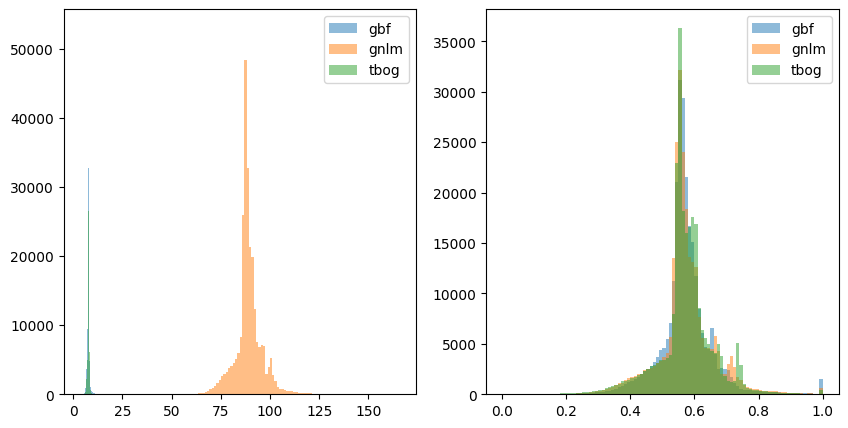

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(output_gbf.flatten(), bins=100, alpha=0.5, label='gbf');
plt.hist(output_gnlm.flatten(), bins=100, alpha=0.5, label='gnlm');
plt.hist(output_tbog.flatten(), bins=100, alpha=0.5, label='tbog');
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(output_gbf_standardized.flatten(), bins=100, alpha=0.5, label='gbf');
plt.hist(output_gnlm_standardized.flatten(), bins=100, alpha=0.5, label='gnlm');
plt.hist(output_tbog_standardized.flatten(), bins=100, alpha=0.5, label='tbog');
plt.legend()

In [11]:
# plt.imsave('/home/nus/Downloads/output_village_gbf.png', output_gbf_standardized.squeeze(), cmap='gray', dpi=300)
# plt.imsave('/home/nus/Downloads/output_village_gnlm.png', output_gnlm_standardized.squeeze(), cmap='gray', dpi=300)
# plt.imsave('/home/nus/Downloads/output_village_tbog.png', output_tbog_standardized.squeeze(), cmap='gray', dpi=300)

### Compute ENL (Quality Assessment Metric)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


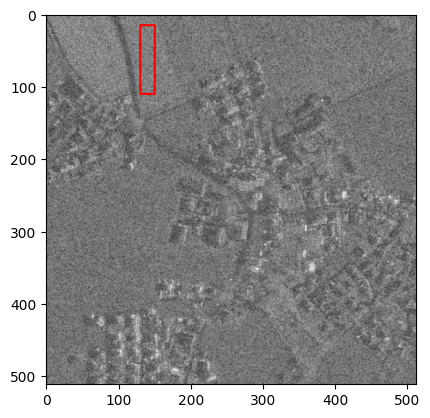

In [32]:
img = np.dstack([T(sar)[0], T(sar)[0], T(sar)[0]]).copy()

xmin, xmax = 130, 150
ymin, ymax = 15, 110
cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
plt.imshow(img, cmap='gray')

In [37]:
window_size = 7
enl_raw = sar[ymin:ymax, xmin:xmax].mean() ** 2 / sar[ymin:ymax, xmin:xmax].var()
enl_gbf = output_gbf_standardized[ymin:ymax, xmin:xmax].mean() ** 2 / output_gbf_standardized[ymin:ymax, xmin:xmax].var()
enl_gnlm = output_gnlm_standardized[ymin:ymax, xmin:xmax].mean() ** 2 / output_gnlm_standardized[ymin:ymax, xmin:xmax].var()
enl_tbog = output_tbog_standardized[ymin:ymax, xmin:xmax].mean() ** 2 / output_tbog_standardized[ymin:ymax, xmin:xmax].var()

print(f"ENL Raw: {enl_raw.mean():.2f}")
print(f"ENL GBF: {enl_gbf.mean():.2f}")
print(f"ENL GNLM: {enl_gnlm.mean():.2f}")
print(f"ENL TBOG: {enl_tbog.mean():.2f}")

ENL Raw: 3.77
ENL GBF: 9309.67
ENL GNLM: 19028.75
ENL TBOG: 44694.76
